# **Telco Customer Churn**

### One of the biggest challenges in the telecom service industry is to retain customers. Neural networks can be a powerfull toll to create a model to forecast if, based on custumer's profile, he or she will churn or not in the future. But one can ask, what are the effects of different network architectures? Here we will build vizualisations of both accuracy and loss of various neural networks. We will clearly see at which point the networks will overfit. 

### We begin by loading the most relevant packages and by building a plotting function. After data reading, we discharge the column customer ID, since it will be useless to us.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import numpy as np

%matplotlib inline

In [2]:
def history_plot(hist_dict):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import itertools
    
    palette = itertools.cycle(sns.color_palette())

    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.75)

    plt.figure(figsize=(8,8))
    
    for label, hist in hist_dict.items():
        plt.plot(hist.history['acc'], color=next(palette), 
                 linestyle='dashed', lw=2, label='{0} - train'.format(label))
        plt.plot(hist.history['val_acc'], color=next(palette),
                 lw=2, label='{0} - val'.format(label))

    #plt.ylim([0.0, 1.05])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy rate')
    plt.title('Accuracy')
    #plt.legend(loc="lower right")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(8,8))
    
    for label, hist in hist_dict.items():
        plt.plot(hist.history['loss'], color=next(palette), 
                 linestyle='dashed', lw=2, label='{0} - train'.format(label))
        plt.plot(hist.history['val_loss'], color=next(palette),
                 lw=2, label='{0} - val'.format(label))

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    #plt.legend(loc="upper right")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [3]:
data = pd.read_csv('./data/data.csv')
data.drop('customerID', axis='columns', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 1.1+ MB


### The column TotalCharges was read as strings, because some of the rows the data is non-numerical. We will transform it into numerical data and discharge some few non-numerical rows. We also create a list with the name of the categorical columns.

In [4]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
print(data.shape)
data.dropna(inplace=True)
print(data.shape)

columns = list(data.columns)
columns.remove('MonthlyCharges')
columns.remove('tenure')
columns.remove('TotalCharges')
print(columns)

(7043, 20)
(7032, 20)
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


### The categorical data will be encoded into numbers.

In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
X = data[columns[:-1]]

le = LabelEncoder()
y = le.fit_transform(data['Churn'])

X = pd.get_dummies(X)

X['MonthlyCharges'] = data['MonthlyCharges']
X['tenure'] = data['tenure']
X['TotalCharges'] = data['TotalCharges']
X[['MonthlyCharges', 'tenure', 'TotalCharges']] = StandardScaler().fit_transform(data[['MonthlyCharges', 'tenure', 'TotalCharges']])

X.shape

(7032, 45)

In [6]:
from keras import utils
X = X.values

/home/rodolfo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
train_class_weights = dict(enumerate(class_weights))
print (train_class_weights, "\n")

{0: 0.6776439089692102, 1: 1.907309721175584} 



In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5062, 45)
(1266, 45)
(704, 45)


In [10]:
y_train_rs = utils.to_categorical(y_train, num_classes=2)
y_val_rs = utils.to_categorical(y_val, num_classes=2)
y_test_rs = utils.to_categorical(y_test, num_classes=2)

## **Number of neurons**

### Here we will build a NN with two hidden layers and we will vary the number of neurons in the first one.

In [11]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout

history = {}
i=1
n_list = [2**i for i in range(5,12)]

for neurons in n_list:
    print('\r Model {0} of {1}'.format(i, len(n_list)))
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(45,)),
        Dense(8, activation='relu'),
        Dropout(0.75),
        Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', 
                  optimizer='sgd', metrics=['accuracy'])
    history['neuros: {0}'.format(neurons)] = model.fit(X_train, y_train_rs,
                                              batch_size=32, epochs=200, verbose=0,
                                              class_weight = train_class_weights, 
                                              validation_data=(X_val, y_val_rs))
    i+=1

 Model 1 of 7
 Model 2 of 7
 Model 3 of 7
 Model 4 of 7
 Model 5 of 7
 Model 6 of 7
 Model 7 of 7


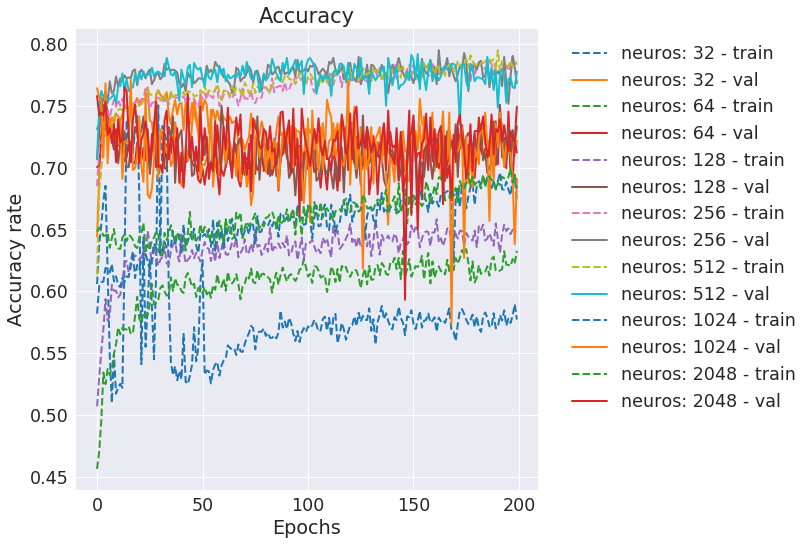

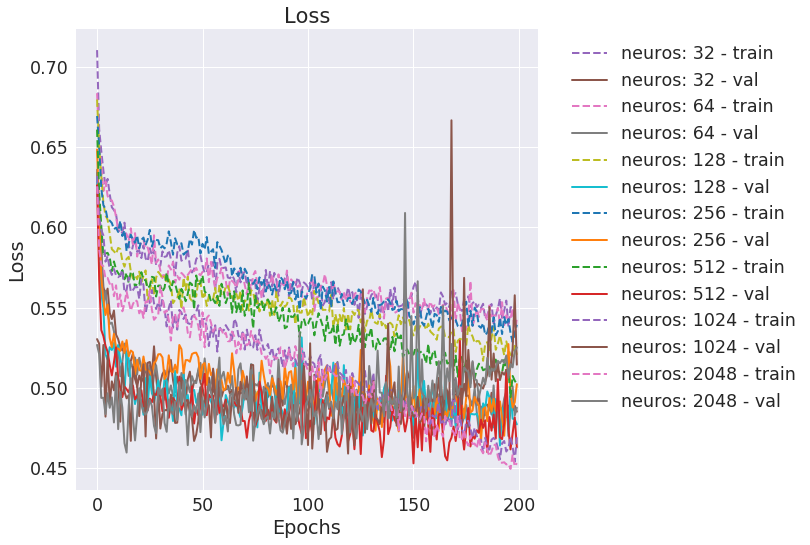

In [12]:
history_plot(history)

## **Number of layers**

### In this experiment we begin with two hidden layers. After, we will add more hidden layers, with the same number of neurons as in the first one.

In [13]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout

history = {}
i=1
n_list = [i for i in range(6)]

for n_layers in n_list:
    print('\r Model {0} of {1}'.format(i, len(n_list)))
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(45,)))
    
    for layer in range(n_layers):
        model.add(Dense(32, activation='relu'))
        
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.75))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='sgd', metrics=['accuracy'])
    history['h-layers: {0}'.format(n_layers+2)] = model.fit(X_train, y_train_rs,
                                              batch_size=32, epochs=200, verbose=0,
                                              class_weight = train_class_weights, 
                                              validation_data=(X_val, y_val_rs))
    i+=1

 Model 1 of 6
 Model 2 of 6
 Model 3 of 6
 Model 4 of 6
 Model 5 of 6
 Model 6 of 6


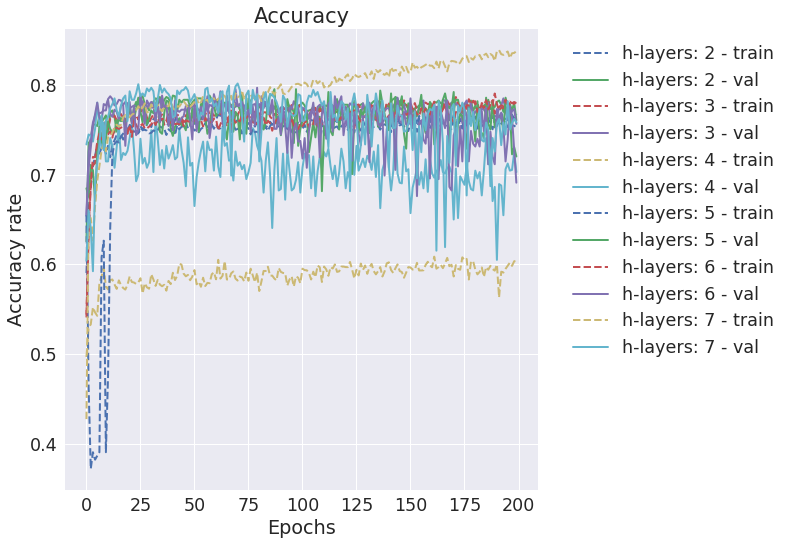

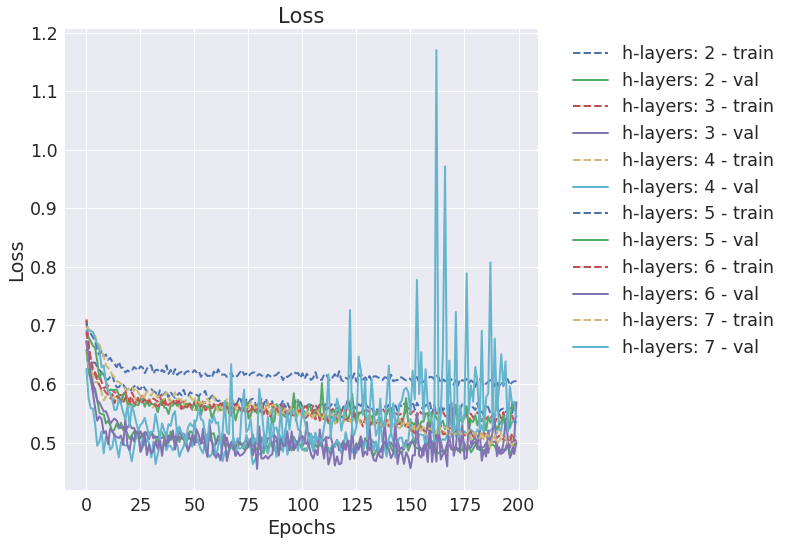

In [14]:
history_plot(history)

## **Regularization**

### Here we vary the regularization parameter of one of the three hidden layers.

In [17]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from keras import regularizers

history = {}
i=1
r_params = [10**(-i) for i in range(0,4)]

for r in r_params:
    print('\r Model {0} of {1}'.format(i, len(r_params)))
    l2 = regularizers.l2(r)
    model = Sequential([
        Dense(32, activation='relu', input_shape=(45,)),
        Dense(32, activation='relu', kernel_regularizer=l2),
        Dense(8, activation='relu'),
        Dropout(0.75),
        Dense(2, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', 
                  optimizer='sgd', metrics=['accuracy'])
    history['regularization: {0}'.format(r)] = model.fit(X_train, y_train_rs,
                                              batch_size=32, epochs=200, verbose=0,
                                              class_weight = train_class_weights, 
                                              validation_data=(X_val, y_val_rs))
    i+=1

 Model 1 of 4
 Model 2 of 4
 Model 3 of 4
 Model 4 of 4


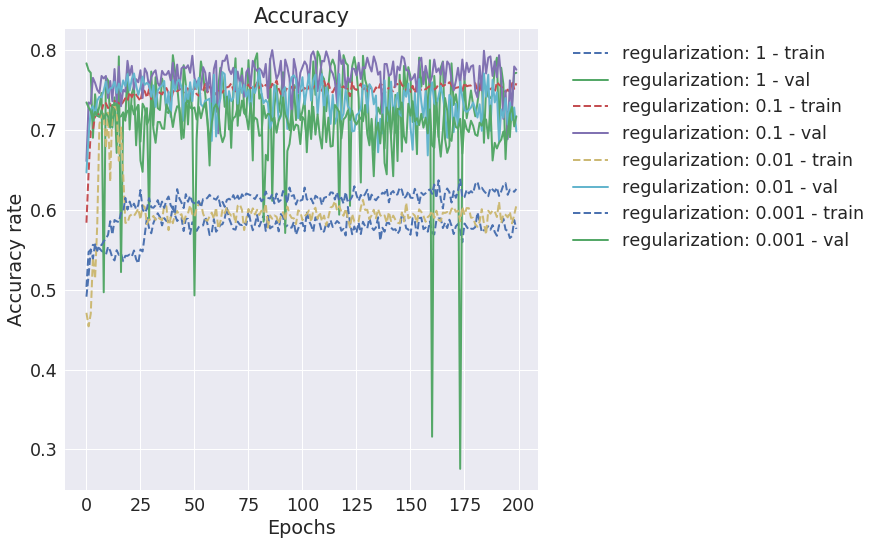

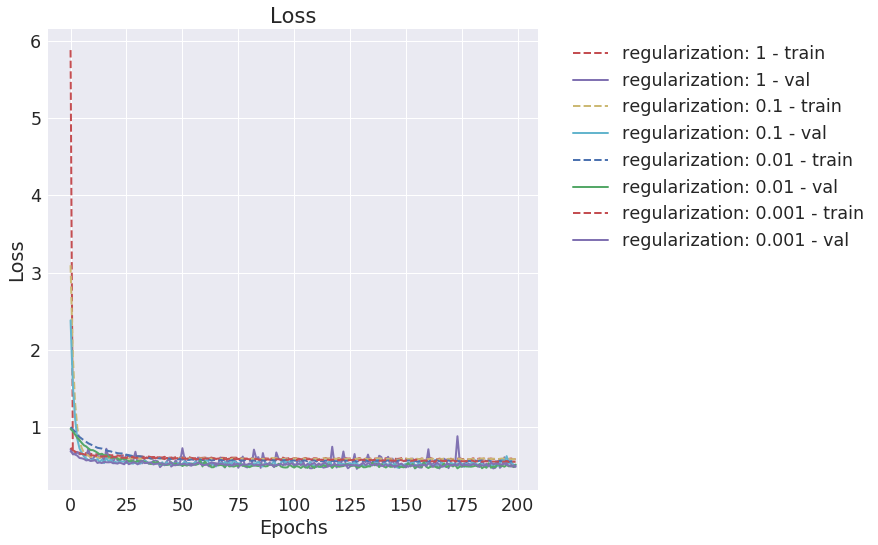

In [18]:
history_plot(history)